# Hello! And Welcome to the final stage of Sha++er. 

## After running match, there should be a file saved to the match folder with the longest match per fragment. Upload this file as 'ans1.csv'.
## Upload that file, and the fasta file and the gff3 file for your model organism as 'genomic.gff' (It is likely already named this).

## Installing Dependencies

In [1]:
!pip install biopython
!pip install gffpandas


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Imports

In [2]:
import pandas as pd
import Bio 
from Bio import SeqIO
from Bio.Seq import Seq
import gffpandas.gffpandas as gffpd
from itertools import repeat

## Create annotations dataframe

In [3]:
annotation = gffpd.read_gff3('genomic.gff')
df_anno = annotation.df
df_gene = df_anno[df_anno['type'] == 'gene']

## Change the input_file variable to the name of your model genome's fasta file name then construct Reference Genome String.


In [7]:
input_file = '<change me>.fna' ## Change Me
input_file = 'c_elegans.fasta'
model = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
reference_list = []
reference = ''
for k in model:
    reference_list.append(str(model.get(k).seq))
reference = ''.join(reference_list)


## Create a dataframe of the fragments. Alter the min_size variable to filer the fragments based on a minimim size (i.e. only annotate fragments greater than x nucleotides.

In [8]:
min_size = 0 # default, not recommended
fragments = pd.read_csv('ans1.csv')
my_list = []
for row in range(len(fragments)):
    my_list.append(len(fragments.iloc[row]['matched']))
fragments['matchedsize'] = my_list
fragments = fragments[fragments['matchedsize'] >= min_size]
fragments.head()


,fragmentID,matched,matchedsize
0,1,CAAAAAAAATAAAAAAAATATAT,23
1,2,TATTATTATTATTATTATTATTATTATTATTATTATTATT,40
2,3,ACACACACACACACACACACACACACACACACACACACACACACAC...,172
3,4,ACACACACACACACCACACACACACACACACACACACACACACACA...,109
4,5,TTGACACACACACACACACACACACACACACACACACACACACACA...,67


## Graph of distribution of length of match to quantity

<AxesSubplot:title={'center':'Normalized Value Counts of Fragment Length'}, xlabel='Fragment Length', ylabel='Frequency'>

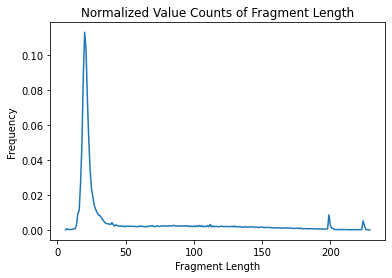

In [14]:
fragments['matchedsize'].value_counts(normalize=True).sort_index().plot(title = 'Normalized Value Counts of Fragment Length', xlabel = 'Fragment Length', ylabel = 'Frequency')

## The brunt of the work: this section will actually perform the annotations. As a time expectation, it will take about 1 minute per 1000 fragments.<br><br> In addition, this will automatically download the result to the directory you are in now when finished, so feel free to go grab a coffee...

In [ ]:
hits_df = df_anno[df_anno['end'] == 0]
if hits_df.empty:
    print('hi')
counts = {}
hitseqs = []
hitlens = []
nonmodel_start = []
nonmodel_end = []
num = 0
for f in fragments.index:
    frag = fragments.loc[f]['matched']
    lenfrag = len(frag)
    start = reference.index(frag)
    end = start + lenfrag
    hits = df_gene.loc[(df_anno['start'] <= start) & (df_anno['end'] >= end)]
    num += 1
    if num%100 == 0:
        print(num)
    if not hits.empty:
        hits_df = pd.concat([hits_df,hits])
        hitseqs.extend(repeat(frag, len(hits)))
        hitlens.extend(repeat(lenfrag, len(hits)))
        nonmodel_start.extend(repeat(start, len(hits)))
        nonmodel_end.extend(repeat(end, len(hits)))
hits_df['fragment'] = hitseqs
hits_df['lengths'] = hitlens
hits_df['nonmodel_start'] = nonmodel_start
hits_df['nonmodel_end'] = nonmodel_end

hits_df.to_csv(r'fragment_annotations.csv', index=False, header=True)